In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn import metrics
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

from scipy.stats import randint

## 1. Load Data

In [0]:
condata = pd.read_csv("https://raw.githubusercontent.com/tnyng/ADAMS_SS19/master/ConversionDataSet.csv")
condata = condata.drop('Unnamed: 0', axis=1)

In [0]:
# Have a overview of the dataset
condata.head()

,month,Kauf,sessionStartHour,dayOfMonth,weekday,sessionTime,category,pageVisitedBeforeSession,amountBasketSession,totalItemValueBasketSession,sessionProduct,sessionSearch,sessionOverview,sessionSale,sessionCart,percPageProduct,percPageSearch,percPageOverview,percPageSale,percPageCart,countPagesRevisited,timeOnPage,checkoutStep,clickEventsSession,scrollEventSession,tabSwitchSession,clickEventProduct,scrollEventProduct,tabSwitchProduct,clickEventSearch,scrollEventSearch,tabSwitchSearch,clickEventOverview,scrollEventOverview,tabSwitchOverview,clickEventSale,scrollEventSale,tabswitchSale,clickEventCart,scrollEventCart,...,recencyVisit,countPagesRevisitedLastSession,currentPageVisitedLastTime,frequencyVisit,totViewCount,totVisitTime,totPurchasesAmount,totPurchasesItems,totProduct,totSearch,totOverview,totSale,totCart,totPercPageOverview,totPercPageProduct,totPercPageSearch,totPercPageSale,totPercPageCart,convertedBefore,hurry,currentViewCountVsPreviousAvg,currentVisitLengthVsAvg,meanRecencyVisit,pageProductrVisit,pageSearchrVisit,pageOverviewrVisit,pageSalerVisit,pageCartrVisit,purchasesrVisit,browser,browserVersion,operatingSystem,operatingSystemVersion,majorCity,screenWidth,screenHeight,windowWidth,windowHeight,tabVisible,visitorKnown
0,8,0,21,1,6,20,overview,0,0.00,0,0,0,1,1,0,0.00,0.00,0.33,0.33,0.0,0,6,0,3,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.5,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,20,0.0,0,0,0,1,1,0,0.00,0.00,0.33,0.33,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,IE,1,Windows 7,1,0,1280,1024,1280,844,1,0
1,8,0,0,1,6,85,search,1,0.00,0,0,2,0,0,0,0.00,0.67,0.00,0.00,0.0,1,34,0,5,10,3,0.0,0.0,0.0,0.266667,0.112741,0.703125,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,85,0.0,0,0,2,0,0,0,0.00,0.67,0.00,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Firefox,2,Windows 8,1,0,1366,768,1339,634,1,1
2,8,0,10,1,6,23,overview,0,0.00,0,0,0,2,0,0,0.00,0.00,0.67,0.00,0.0,0,4,0,3,2,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,23,0.0,0,0,0,2,0,0,0.00,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Chrome,2,Windows 8.1,1,0,1600,900,1600,799,1,1
3,8,0,8,1,6,162,overview,1,9.95,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,1,67,0,3,23,3,0.5,0.0,1.0,0.000000,0.000000,0.000000,0.666667,0.045554,0.666667,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,162,0.0,0,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Firefox,2,Windows 7,1,0,1280,1024,1280,891,1,1
4,8,0,17,1,6,52,product,0,39.90,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,6,0,2,3,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,52,0.0,0,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,Chrome,2,Windows 7,1,1,1600,900,1600,775,1,1


In [0]:
condata.shape 

(51349, 96)

#### There are 51349 observations, i.e. clients and 96 features, i.e. information or activities of the clients, where "Kauf" is regarded as the target variable. However, we still need to check whether the dataset is balanced, that is, whether the two classes of the target variable are equally distributed. An imbalanced data structure might lead to an illegal result (high prediction accuracy) in the end, because the model will focus mainly on the majority class. 

In [0]:
class_counts = condata.groupby('Kauf').size()
print(class_counts)

Kauf
0    47237
1     4112
dtype: int64


#### As we could see, the dataset is imbalanced. Whereas there are 47237 observations in the positive class, i.e. clients who did not convert to purchase, only 4112 are in the negative class, which means only a small portion of the clients actually converted to purchase. 
#### In the next step, we then transform some of our feature types.

In [0]:
# Transform the categorical features into numeric data types
encoder = LabelEncoder()
condata["category"] = encoder.fit_transform(condata["category"])
condata["browser"] = encoder.fit_transform(condata["browser"])
condata["operatingSystem"] = encoder.fit_transform(condata["operatingSystem"])
condata.head()

,month,Kauf,sessionStartHour,dayOfMonth,weekday,sessionTime,category,pageVisitedBeforeSession,amountBasketSession,totalItemValueBasketSession,sessionProduct,sessionSearch,sessionOverview,sessionSale,sessionCart,percPageProduct,percPageSearch,percPageOverview,percPageSale,percPageCart,countPagesRevisited,timeOnPage,checkoutStep,clickEventsSession,scrollEventSession,tabSwitchSession,clickEventProduct,scrollEventProduct,tabSwitchProduct,clickEventSearch,scrollEventSearch,tabSwitchSearch,clickEventOverview,scrollEventOverview,tabSwitchOverview,clickEventSale,scrollEventSale,tabswitchSale,clickEventCart,scrollEventCart,...,recencyVisit,countPagesRevisitedLastSession,currentPageVisitedLastTime,frequencyVisit,totViewCount,totVisitTime,totPurchasesAmount,totPurchasesItems,totProduct,totSearch,totOverview,totSale,totCart,totPercPageOverview,totPercPageProduct,totPercPageSearch,totPercPageSale,totPercPageCart,convertedBefore,hurry,currentViewCountVsPreviousAvg,currentVisitLengthVsAvg,meanRecencyVisit,pageProductrVisit,pageSearchrVisit,pageOverviewrVisit,pageSalerVisit,pageCartrVisit,purchasesrVisit,browser,browserVersion,operatingSystem,operatingSystemVersion,majorCity,screenWidth,screenHeight,windowWidth,windowHeight,tabVisible,visitorKnown
0,8,0,21,1,6,20,6,0,0.00,0,0,0,1,1,0,0.00,0.00,0.33,0.33,0.0,0,6,0,3,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.5,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,20,0.0,0,0,0,1,1,0,0.00,0.00,0.33,0.33,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,5,1,0,1280,1024,1280,844,1,0
1,8,0,0,1,6,85,9,1,0.00,0,0,2,0,0,0,0.00,0.67,0.00,0.00,0.0,1,34,0,5,10,3,0.0,0.0,0.0,0.266667,0.112741,0.703125,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,85,0.0,0,0,2,0,0,0,0.00,0.67,0.00,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,6,1,0,1366,768,1339,634,1,1
2,8,0,10,1,6,23,6,0,0.00,0,0,0,2,0,0,0.00,0.00,0.67,0.00,0.0,0,4,0,3,2,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,23,0.0,0,0,0,2,0,0,0.00,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,7,1,0,1600,900,1600,799,1,1
3,8,0,8,1,6,162,6,1,9.95,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,1,67,0,3,23,3,0.5,0.0,1.0,0.000000,0.000000,0.000000,0.666667,0.045554,0.666667,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,162,0.0,0,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,5,1,0,1280,1024,1280,891,1,1
4,8,0,17,1,6,52,7,0,39.90,1,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,6,0,2,3,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,...,-1,0,0,0,3,52,0.0,0,1,0,2,0,0,0.33,0.00,0.67,0.00,0.0,0,0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,5,1,1,1600,900,1600,775,1,1


In [0]:
# set seed
np.random.seed(123)

# split data into X and y
X = condata.loc[:, condata.columns != "Kauf"]
y = condata["Kauf"]

# standardize the features in the dataset
col_names = X.columns
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col_names)

# split data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(30809, 95) (30809,) (10270, 95) (10270,) (10270, 95) (10270,)


#### As shown, after splitting, we get 60% training data, 20% validation and 20% test data.

## 2. Grid Search for Parameters

In [0]:
# Using Keras for modelling
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Layer, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.objectives import binary_crossentropy
from keras import objectives, optimizers
from keras.losses import mse, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [0]:
# built the model 
def nn_model():
  model = Sequential()

  model.add(Dense(128,
                  activation='relu', 
                  kernel_regularizer=l2(0.01),
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42),
                  input_dim = 95)) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256, 
                  activation='relu', 
                  kernel_regularizer=l2(0.01), 
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256, 
                  activation='relu', 
                  kernel_regularizer=l2(0.01), 
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(128, 
                 activation='relu', 
                 kernel_regularizer=l2(0.01), 
                 bias_initializer='zeros',
                 kernel_initializer=keras.initializers.he_normal(seed=42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1, 
                 activation='sigmoid',
                 kernel_regularizer=l2(0.01), 
                 bias_initializer='zeros',
                 kernel_initializer=keras.initializers.glorot_normal(seed=42))) 
  model.add(BatchNormalization())
  model.add(Activation('sigmoid')) 
  
  model.compile(optimizer=Adam(lr=0.0001),
               loss='binary_crossentropy',
               metrics=['accuracy'])

  return model

In [0]:
# create model
model = KerasClassifier(build_fn=nn_model, verbose=0, epochs=100) # since early stopping is implemented, we choose a larger number of epochs to ensure sufficient implementation before early stopping

In [0]:
# define the batch size parameter for grid search
batch_size = [32, 64, 128]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.719251 using {'batch_size': 32}
0.719251 (0.002308) with: {'batch_size': 32}
0.709477 (0.001374) with: {'batch_size': 64}
0.708092 (0.009399) with: {'batch_size': 128}


In [0]:
# define the batch size parameters for grid search
batch_size = [32, 64, 128]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.719251 using {'batch_size': 32}
0.719251 (0.002308) with: {'batch_size': 32}
0.709477 (0.001374) with: {'batch_size': 64}
0.708092 (0.009399) with: {'batch_size': 128}


In [0]:
# Next, built the model for learning rate grid search
def nn_opt(lr=1e-4):
  model = Sequential()

  model.add(Dense(128,
                  activation='relu', 
                  kernel_regularizer=l2(0.01),
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42),
                  input_dim = 95)) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256, 
                  activation='relu', 
                  kernel_regularizer=l2(0.01), 
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(256, 
                  activation='relu', 
                  kernel_regularizer=l2(0.01), 
                  bias_initializer='zeros',
                  kernel_initializer=keras.initializers.he_normal(seed = 42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(128, 
                 activation='relu', 
                 kernel_regularizer=l2(0.01), 
                 bias_initializer='zeros',
                 kernel_initializer=keras.initializers.he_normal(seed=42)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1, 
                 activation='sigmoid',
                 kernel_regularizer=l2(0.01), 
                 bias_initializer='zeros',
                 kernel_initializer=keras.initializers.glorot_normal(seed=42))) 
  model.add(BatchNormalization())
  model.add(Activation('sigmoid'))
  
  model.compile(optimizer=Adam(lr=lr),
               loss='binary_crossentropy',
               metrics=['accuracy'])

  return model


In [0]:
model = KerasClassifier(build_fn=nn_opt, verbose=0, epochs=100, batch_size=32)

In [0]:
# define the learning rate parameters
lr = [0.0001, 0.0003, 0.0005, 0.0007]
param_grid = dict(lr=lr)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=3)
grid_result2 = grid.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

## 3. Modelling and Training

In [0]:
model = Sequential()

model.add(Dense(128,
                activation='relu', 
                kernel_regularizer=l2(0.01),
                bias_initializer='zeros',
                kernel_initializer=keras.initializers.he_normal(seed = 42),
                input_dim = 95)) # input dimension is set to 95, as we have 95 features.
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, 
                activation='relu', 
                kernel_regularizer=l2(0.01), 
                bias_initializer='zeros',
                kernel_initializer=keras.initializers.he_normal(seed = 42)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128, 
                activation='relu', 
                kernel_regularizer=l2(0.01), 
                bias_initializer='zeros',
                kernel_initializer=keras.initializers.he_normal(seed=42)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, 
                activation='sigmoid',
                kernel_regularizer=l2(0.01), 
                bias_initializer='zeros',
                kernel_initializer=keras.initializers.glorot_normal(seed=42))) 
model.add(BatchNormalization())
model.add(Activation('sigmoid')) # since we are dealing with binary classification, sigmoid is chosen as the activation function in the output layer.

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12288     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_2

In [0]:
# Compile the model with Adam optimizer with searched learning rate
model.compile(optimizer=Adam(0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
# Fit the model using searched batch size
cb = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=0, 
                   patience=8,
                   restore_best_weights=True)

model.fit(x=X_train, 
          y=y_train,
          validation_data=[X_val, y_val],
          epochs=100, 
          batch_size=32,
          callbacks=[cb])

Instructions for updating:
Use tf.cast instead.
Train on 30809 samples, validate on 10270 samples
Epoch 1/100
 6176/30809 [=====>........................] - ETA: 1:43 - loss: 10.2326 - acc: 0.5102

## 4. Predicting


#### Since the dataset is imbalanced, instead of using accuracy, we will apply AUC score as the evaluation measure.

In [0]:
# Make predictions
pred_val = model.predict(X_val)
pred = model.predict(X_test)
print('AUC in the val. set: ', metrics.roc_auc_score(y_val, pred_val))
print('AUC in the test set: ', metrics.roc_auc_score(y_test, pred))

AUC in the val. set:  0.7326838265000172
AUC in the test set:  0.731873837052737


AUC in the val. set:  0.7326838265000172
AUC in the test set:  0.731873837052737


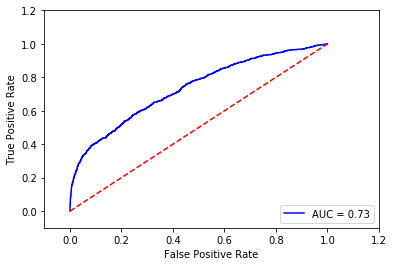

In [0]:
pred_val = model.predict(X_val)
pred = model.predict(X_test)

def show_AUC(y_test, pred):
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)

  plt.plot(false_positive_rate, true_positive_rate, 'b',
  label='AUC = %0.2f'% roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.2])
  plt.ylim([-0.1,1.2])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  
print('AUC in the val. set: ', metrics.roc_auc_score(y_val, pred_val))
print('AUC in the test set: ', metrics.roc_auc_score(y_test, pred))
show_AUC(y_test, pred)

#### As a result, we get a AUC score of 0.74. For further improvement, it would be helpful if we implement grid search for more hyperparameters, such as optimizers, dropout rate and momentum. In addition, random search for hyperparameter optimization and the comparison between both methods are also worth trying.